In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn import metrics

from scipy.stats import skew, kurtosis, norminvgauss, norm


In [2]:
# def best_EM(data, n_components_range, verbose=None):
#     lowest_aic, lowest_bic = np.inf, np.inf
#     bic = []
#     aic = []
#     best_n_components = n_components_range[0]
#     for n_components in n_components_range:
#         gmm = GaussianMixture(n_components=n_components)
#         gmm.fit(data)
#         aic.append(gmm.aic(data))
#         if aic[-1] < lowest_aic:
#             lowest_aic = aic[-1]
#             best_n_components = n_components
#             print('_____________________________')
#             print(f'best number of components \t aic\n{best_n_components} \t\t {lowest_aic}')
         
#     return best_n_components

In [2]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def BIC_evaluation(data, n_components, iterations=20):
    bics=[]
    bics_err=[]
    for n in n_components:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(data) 
            tmp_bic.append(gmm.bic(data))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)
        print('_____________________________________')
        print(f'n_components: {n}\tmean BIC: {val}')
    
    return bics, bics_err

# 1. Загрузка данных

In [3]:
day_return = pd.read_csv('DATA/EURUSD_Day_RETURN_05.05.2003-29.04.2020.csv')
hour_return = pd.read_csv('DATA/EURUSD_Hour_RETURN_05.05.2003-29.04.2020.csv')
minute_return = pd.read_csv('DATA/EURUSD_Minute_RETURN_29.04.2019-29.04.2020.csv')

In [4]:
day_return.iloc[[0,-1], :]

,Close
0,0.013773
4431,0.002963


In [5]:
hour_return.iloc[[0,-1], :]

,Close
0,0.000187
106369,-0.000451


In [6]:
minute_return.iloc[[0,-1], :]

,Close
0,0.000045
380158,0.000055


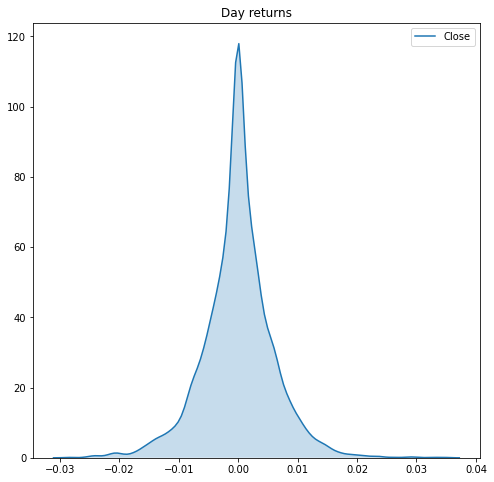

In [7]:
plt.figure(figsize=(8,8))

sns.kdeplot(data=day_return.iloc[:, 0], shade=True);
plt.title('Day returns')

plt.show()

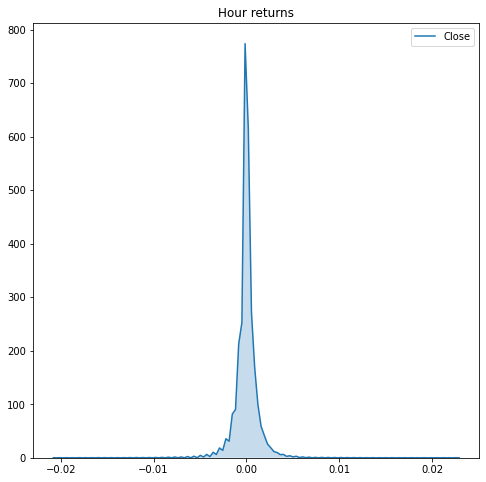

In [8]:
plt.figure(figsize=(8,8))

sns.kdeplot(data=hour_return.iloc[:, 0], shade=True);
plt.title('Hour returns')

plt.show()

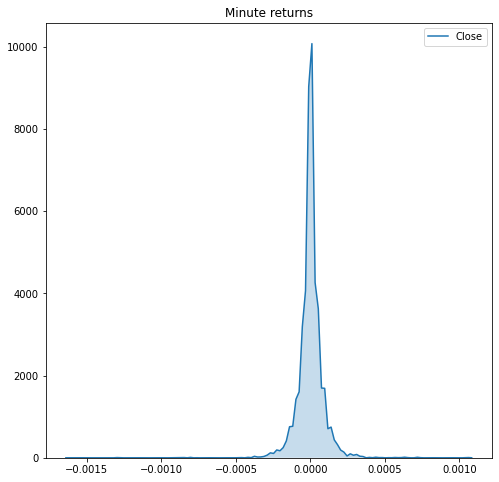

In [9]:
plt.figure(figsize=(8,8))

sns.kdeplot(minute_return.iloc[:6000, 0], shade=True);
plt.title('Minute returns')

plt.show()

# 2. Поиск оптимального числа гауссиан в смеси

Посмотрим как будет меняться BIC с увеличением количества компонент гауссовой смеси на дневных, часовых и минутных возвратах. Построим графики зависимости BIC и градиента BIC от количества компонент и выберем разбиение с наименьшим значением BIC

## Дневные возвраты

In [34]:
n_components = np.arange(2, 50)
bics, bics_err = BIC_evaluation(day_return, n_components)

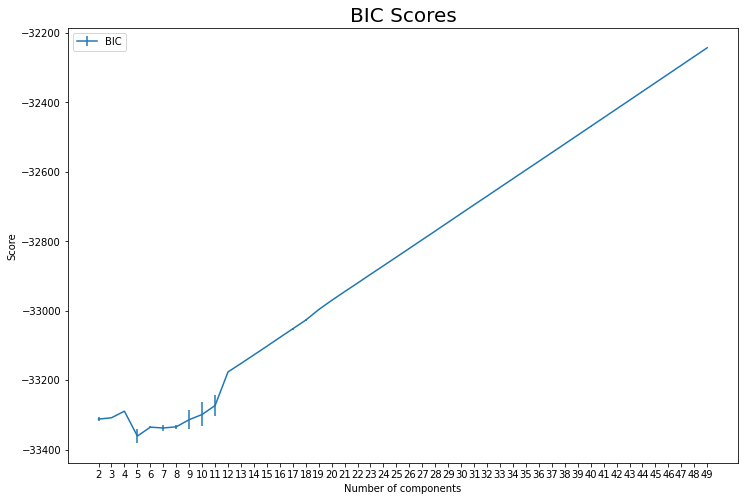

In [38]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.legend()

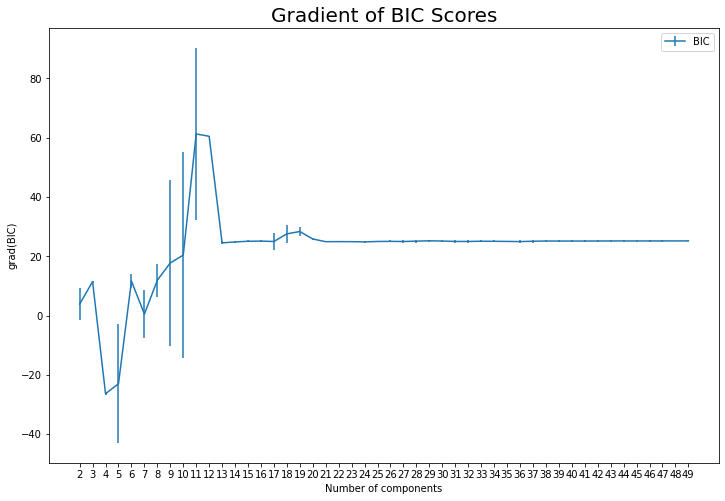

In [40]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("grad(BIC)")
plt.legend()

Из графиков видно, что лучшим числом разбиений данных на кластеры будет 5. Проверим насколько хорошо смесь из 5 гауссиан приблизит эмпирическое распределение дневных возвратов. Особое внимание уделим хвостам, т.к. именно риски/ редкие события с большим отклонением от вершины распределения интересуют нас больше всего.

## Смесь гауссиан для дневных возвратов

In [4]:
day_gmm = GaussianMixture(n_components=5)
day_gmm.fit(day_return)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [5]:
day_gmm.aic(day_return)

-33449.78563501642

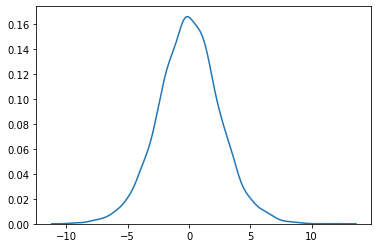

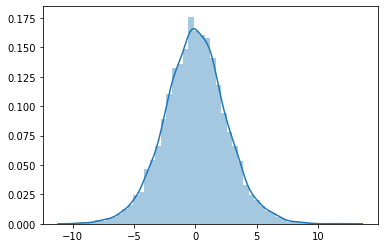

In [470]:
n = 10000 # number of sample to be drawn
mu = day_gmm.means_
sigma = [2, 3]
samples = []
for i in range(n): # iteratively draw samples
    Z = np.random.choice([0,1]) # latent variable
    samples.append(np.random.normal(mu[Z], sigma[Z], 1))
sns.distplot(samples, hist=False)
plt.show()
sns.distplot(samples)
plt.show()

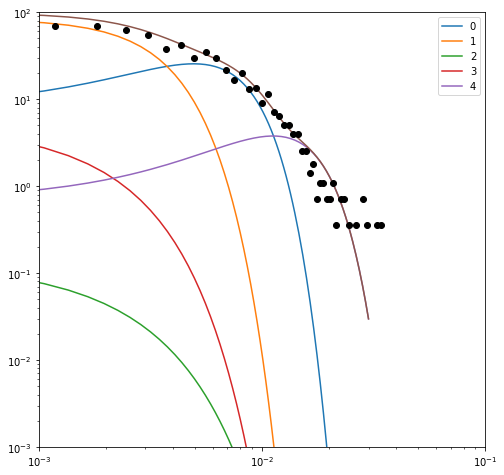

In [472]:
plt.figure(figsize=(8,8))
plt.axis([10**(-3), 10**(-1), 10**(-3), 10**(2)])

plt.yscale('log')
plt.xscale('log')
x = np.linspace(-0.03, 0.03, 200)
mixture = np.zeros(200)
for i in range(day_gmm.n_components):
    plt.plot(x, day_gmm.weights_[i] * norm(day_gmm.means_[i], np.sqrt(day_gmm.covariances_[i])).pdf(x)[0], label=i)
    mixture += day_gmm.weights_[i] * norm(day_gmm.means_[i], np.sqrt(day_gmm.covariances_[i])).pdf(x)[0]
plt.plot(x, mixture)
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black')
#sns.kdeplot(day_gmm.sample(day_return.shape[0])[0][:, 0], label='5 Gaussians')
plt.legend()
plt.show()

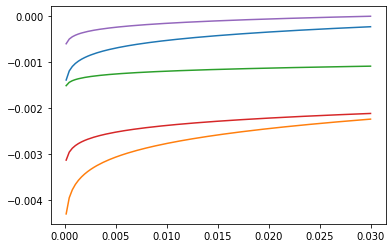

In [473]:
mixture_ppf = np.zeros(200)
for i in range(day_gmm.n_components):
    plt.plot(x, day_gmm.weights_[i] * norm(day_gmm.means_[i], np.sqrt(day_gmm.covariances_[i])).ppf(x)[0], label=i)
    mixture_ppf += day_gmm.weights_[i] * norm(day_gmm.means_[i], np.sqrt(day_gmm.covariances_[i])).ppf(x)[0]

In [474]:
qq_day_hist = np.histogram(day_return ,bins = 200, normed=True)
qq_mixt_hist = np.histogram(day_gmm.sample(day_return.shape[0])[0][:, 0],bins = 200, normed=True)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


In [475]:
actual_day_data_sorted = sorted(qq_day_hist[1][:-1])
mixt_sorted = sorted(qq_mixt_hist[1][:-1])

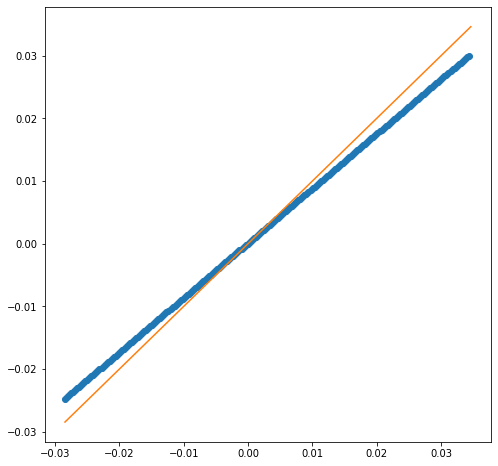

In [480]:
plt.figure(figsize=(8,8))

a = np.arange(0, 10)
plt.plot(actual_day_data_sorted, mixt_sorted, 'o')
plt.plot(actual_data_sorted, actual_data_sorted)
plt.show()

In [380]:
import pylab 
import scipy.stats as stats

stats.probplot(day_return.iloc[:, 0], dist=mixture, plot=pylab)
pylab.show()

AttributeError: 'numpy.ndarray' object has no attribute 'ppf'

In [346]:
def gaussian_mixture(gmm):
    x = np.linspace(-0.03, 0.03, 200)
    gaussians = []
    for i in range(gmm.n_components):
        #gaussians.append(norm(gmm.means_[i], gmm.covariances_[i]))
        gaussians.append(np.random.normal(gmm.means_[i], covariances_[i], 1))
    y = gmm.weights_ * gaussians(x)
    plt.plot(x, y)
    plt.show()

In [347]:
gaussian_mixture(day_gmm)

TypeError: 'list' object is not callable

In [328]:
np.array.apply?

Object `np.array.apply` not found.


In [324]:
np.linspace?

In [21]:
day_return_hist = np.histogram(day_return ,bins = 100, normed=True)
day_return_hist

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


(array([  0.3575826 ,   0.        ,   0.        ,   0.        ,
          0.3575826 ,   0.        ,   1.43033042,   0.3575826 ,
          0.3575826 ,   0.3575826 ,   0.71516521,   1.78791302,
          1.43033042,   1.43033042,   1.07274781,   0.3575826 ,
          1.43033042,   1.43033042,   2.14549563,   2.86066084,
          3.21824344,   4.29099126,   3.93340865,   6.79406949,
          6.43648689,   6.43648689,   6.43648689,   8.58198251,
          8.58198251,  11.80022596,  10.36989554,  16.80638242,
         22.17012149,  22.8852867 ,  24.67319973,  30.75210401,
         32.89759963,  36.11584308,  47.91606903,  42.19474736,
         55.06772113,  56.49805155,  63.29212104,  74.73476439,
         85.81982513, 217.41022367,  77.23784262,  68.65586011,
         69.01344271,  61.86179062,  55.06772113,  37.9037561 ,
         41.83716475,  29.67935619,  35.04309526,  30.0369388 ,
         21.45495628,  16.44879982,  20.02462586,  13.23055637,
         13.58813898,   8.93956512,  11.

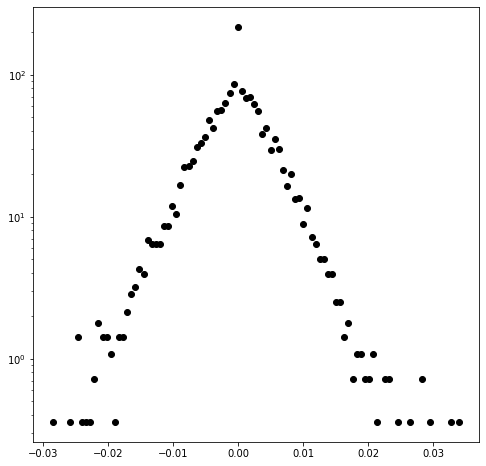

In [22]:
plt.figure(figsize=(8,8))
plt.yscale('log')

plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black')


/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


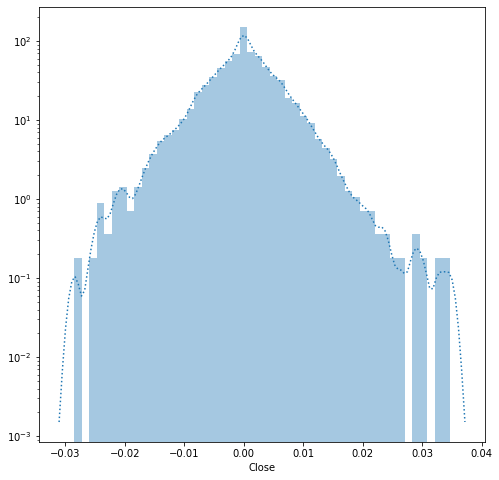

In [19]:
plt.figure(figsize=(8,8))
plt.yscale('log')

sns.distplot(day_return.iloc[:, 0], label='Day returns', kde_kws={'linestyle':'dotted'}, bins=)

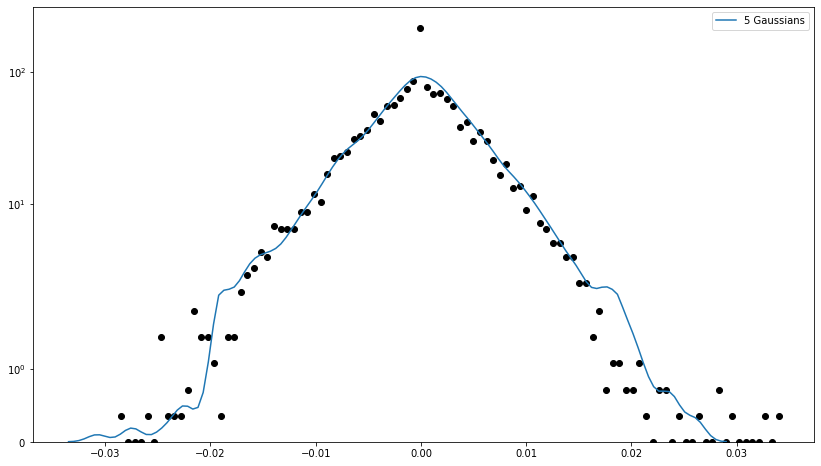

In [31]:
plt.figure(figsize=(14,8))
plt.yscale('symlog')

#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black')
sns.kdeplot(day_gmm.sample(day_return.shape[0])[0][:, 0], label='5 Gaussians')
plt.legend()

plt.show()

In [28]:
plt.yscale?

In [195]:
day_return_hist = np.histogram(day_return ,bins = 100)
day_gmm_hist = np.histogram(day_gmm.sample(day_return.shape[0])[0], bins=100)

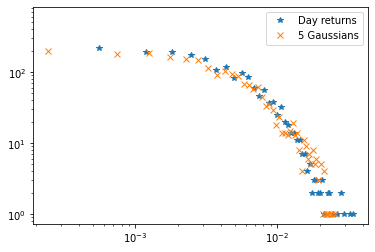

In [196]:
plt.yscale('log')
plt.xscale('log')
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'*', label='Day returns')
plt.plot(day_gmm_hist[1][:-1],day_gmm_hist[0],'x', label='5 Gaussians')
plt.legend()
plt.show()

Смесь из 5 гауссиан достаточно неплохо приближает вершину распределения дневных возвратов. Хвост смеси гауссовых распределениий почти полностью совпадает с хвостом эмпирического распределения. 

## Часовые возвраты 

In [82]:
n_components = np.arange(2, 50)
bics, bics_err = BIC_evaluation(hour_return, n_components)

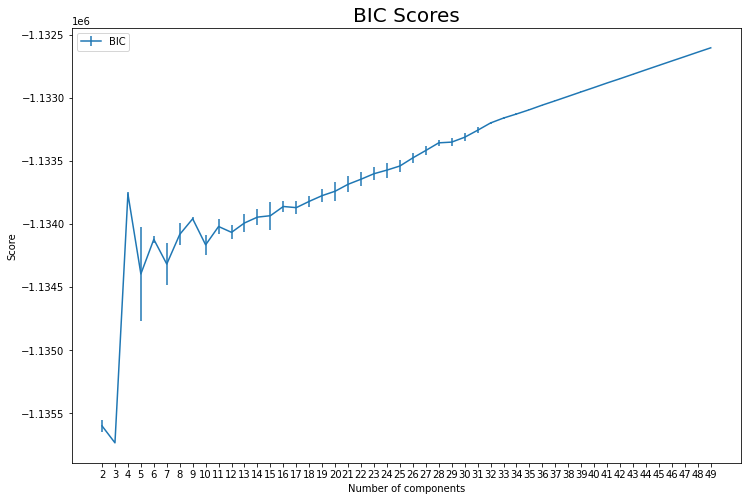

In [83]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.legend()

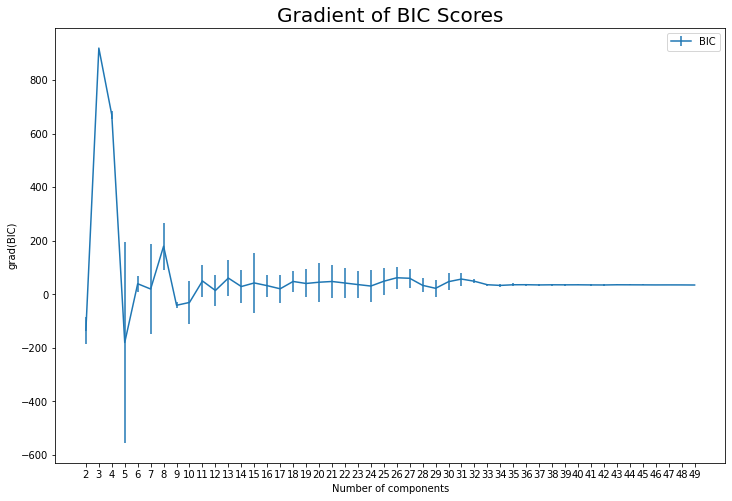

In [84]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("grad(BIC)")
plt.legend()

## Смесь гауссиан для часовых возвратов

In [52]:
hour_gmm = GaussianMixture(n_components=8, reg_covar=1e-07, tol=0.001, random_state=42)
hour_gmm.fit(hour_return)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-07, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [53]:
hour_gmm.aic(hour_return)

-1177261.4418870592

In [133]:
hour_return_hist = np.histogram(hour_return ,bins = 100, normed=True)


/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [134]:
'''norm'''
loc, scale = norm.fit(hour_return['Close'])
Norm_hour = norm(loc, scale)

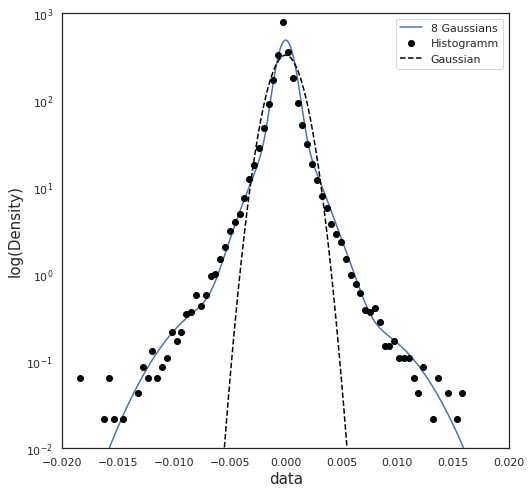

In [160]:
plt.figure(figsize=(8,8))

#plt.axis([10**(-3), 10**(-1), 10**(-3), 10**(2)])
plt.axis([-0.02, 0.02, 10**(-2), 10**(3)])

plt.yscale('log')
#plt.axis([-0.02, 0.02, 0, 800])

#plt.xscale('log')
x = np.linspace(-0.02, 0.02, 500)
mixture = np.zeros(500)
for i in range(hour_gmm.n_components):
    #plt.plot(x, hour_gmm.weights_[i] * norm(hour_gmm.means_[i], np.sqrt(hour_gmm.covariances_[i])).pdf(x)[0], label=i)
    mixture += hour_gmm.weights_[i] * norm(hour_gmm.means_[i], np.sqrt(hour_gmm.covariances_[i])).pdf(x)[0]
plt.plot(x, mixture, label='8 Gaussians')
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o',  color='black', label='Histogramm')
#sns.kdeplot(hour_gmm.sample(hour_return.shape[0])[0][:, 0], label='5 Gaussians')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()

plt.show()

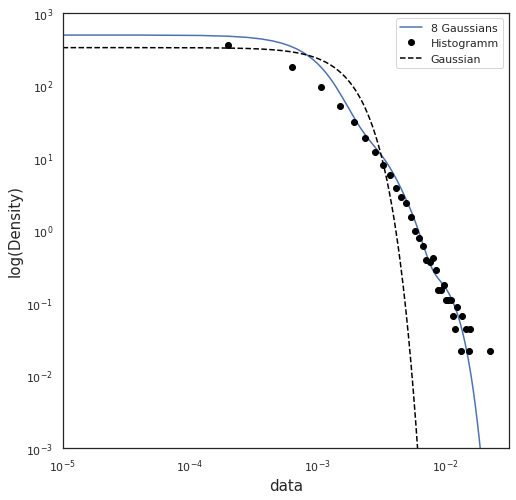

In [169]:
plt.figure(figsize=(8,8))

plt.axis([10**(-5), 10**(-1.5), 10**(-3), 10**(3)])
#plt.axis([-0.02, 0.02, 10**(-2), 10**(3)])

plt.yscale('log')
plt.xscale('log')
#plt.axis([-0.02, 0.02, 0, 800])

#plt.xscale('log')
x = np.linspace(-0.02, 0.02, 500)
mixture = np.zeros(500)
for i in range(hour_gmm.n_components):
    #plt.plot(x, hour_gmm.weights_[i] * norm(hour_gmm.means_[i], np.sqrt(hour_gmm.covariances_[i])).pdf(x)[0], label=i)
    mixture += hour_gmm.weights_[i] * norm(hour_gmm.means_[i], np.sqrt(hour_gmm.covariances_[i])).pdf(x)[0]
plt.plot(x, mixture, label='8 Gaussians')
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o',  color='black', label='Histogramm')
#sns.kdeplot(hour_gmm.sample(hour_return.shape[0])[0][:, 0], label='5 Gaussians')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()

plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


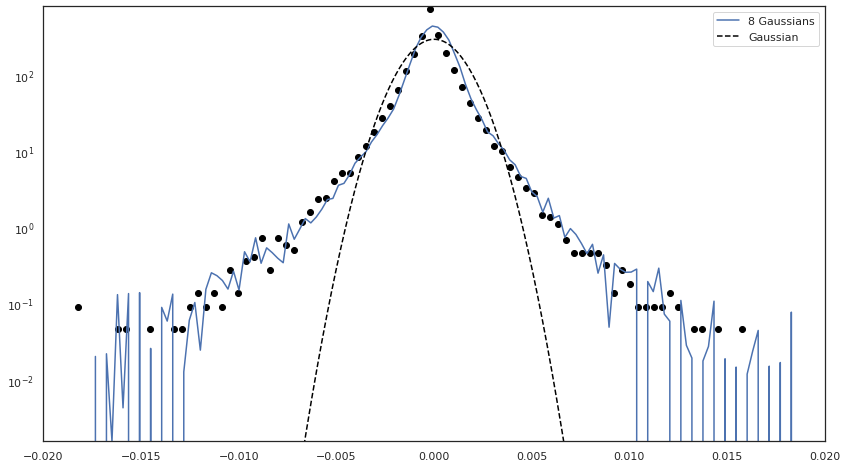

In [131]:
plt.figure(figsize=(14,8))
plt.axis([-0.02, 0.02, 0, 801])

plt.yscale('log')


#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o',  color='black')
sns.kdeplot(hour_gmm.sample(hour_return.iloc[:int(hour_return.shape[0]/2)].shape[0])[0][:, 0], label='8 Gaussians')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')

plt.legend()

plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


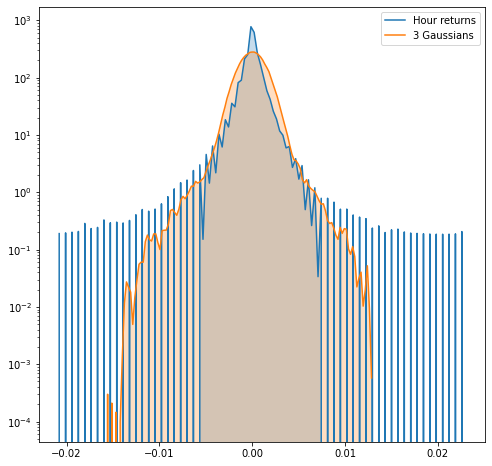

In [164]:
plt.figure(figsize=(8,8))
plt.yscale('log')

sns.kdeplot(data=hour_return.iloc[:, 0], label='Hour returns', shade=True)
sns.kdeplot(hour_gmm.sample(hour_return.shape[0])[0][:, 0], label='3 Gaussians', shade=True)
plt.legend()

plt.show()

In [254]:
hour_return_hist = np.histogram(hour_return ,bins = 100, normed=True)
hour_gmm_hist = np.histogram(hour_gmm.sample(hour_return.shape[0])[0], bins=100, normed=True)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


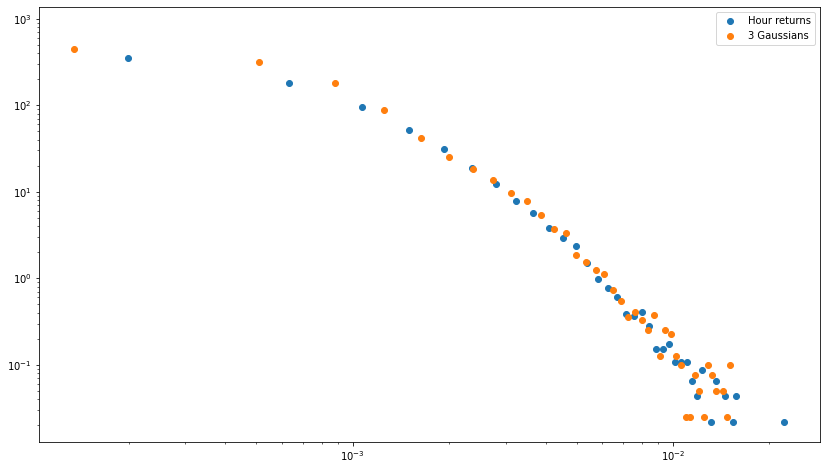

In [258]:
plt.figure(figsize=(14,8))

plt.yscale('log')
plt.xscale('log')
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o', label='Hour returns')
plt.plot(hour_gmm_hist[1][:-1],hour_gmm_hist[0],'o', label='3 Gaussians')
plt.legend()
plt.show()

## Минутные возвраты

In [159]:
n_components = [i for i in range(2, 200, 20)]
bics, bics_err = BIC_evaluation(minute_return[:50000], n_components, iterations=5)

_____________________________________
n_components: 2	mean BIC: -598125.38400863
_____________________________________
n_components: 22	mean BIC: -597502.3556568986
_____________________________________
n_components: 42	mean BIC: -596853.1688763747
_____________________________________
n_components: 62	mean BIC: -596203.9821290687
_____________________________________
n_components: 82	mean BIC: -595554.7954291339
_____________________________________
n_components: 102	mean BIC: -594905.6087316353
_____________________________________
n_components: 122	mean BIC: -594256.4220202838
_____________________________________
n_components: 142	mean BIC: -593607.2353232322
_____________________________________
n_components: 162	mean BIC: -592958.0486261499
_____________________________________
n_components: 182	mean BIC: -592308.8619290827


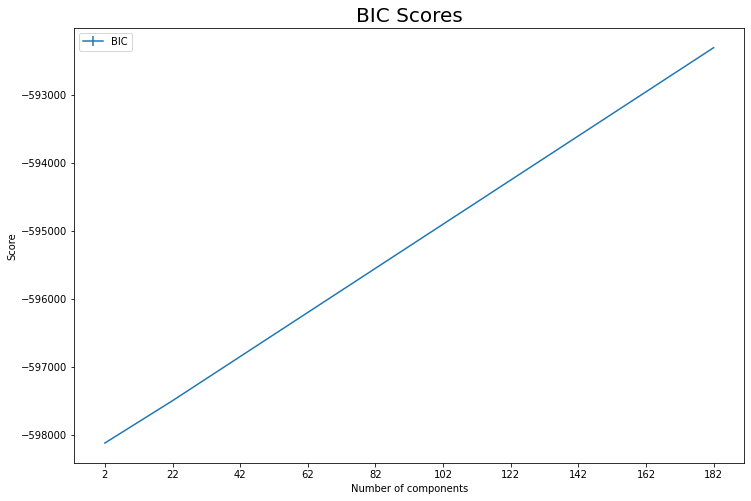

In [160]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.legend()

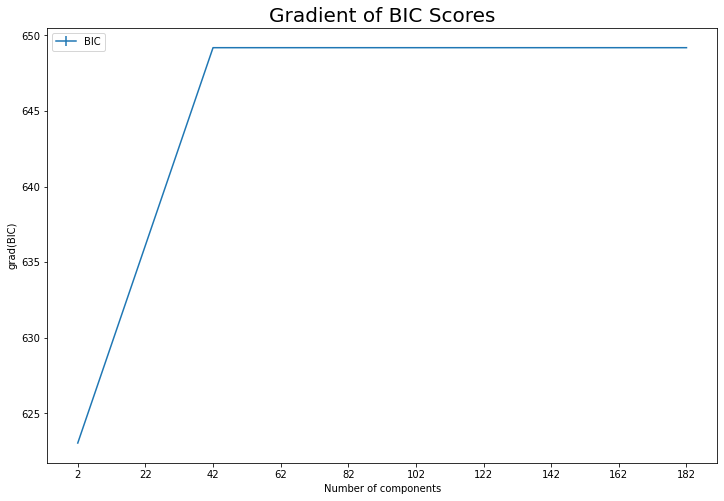

In [172]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("grad(BIC)")
plt.legend()

## Смесь гауссиан для минутных возвратов

In [230]:
minute_gmm = GaussianMixture(n_components=8, covariance_type='full', reg_covar=1e-08)
minute_gmm.fit(minute_return)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-08, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [231]:
minute_return_hist = np.histogram(minute_return ,bins = 100, normed=True)


/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


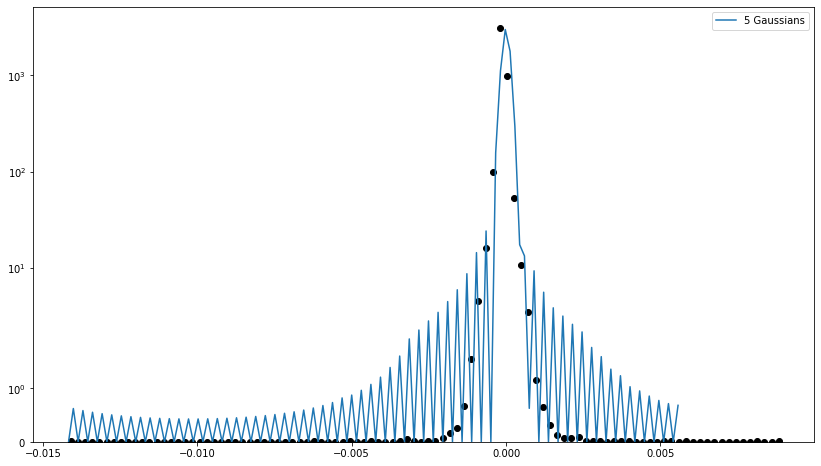

In [232]:
plt.figure(figsize=(14,8))
plt.yscale('symlog')

#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(minute_return_hist[1][:-1],minute_return_hist[0],'o',  color='black')
sns.kdeplot(minute_gmm.sample(minute_return.shape[0])[0][:, 0], label='5 Gaussians')
plt.legend()

plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


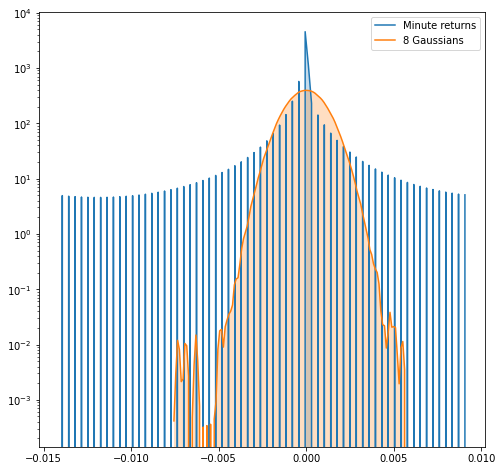

In [169]:
plt.figure(figsize=(8,8))
plt.yscale('log')

sns.kdeplot(data=minute_return.iloc[:, 0], label='Minute returns', shade=True)
sns.kdeplot(minute_gmm.sample(minute_return.shape[0])[0][:, 0], label='8 Gaussians', shade=True)
plt.legend()

plt.show()

In [234]:
minute_return_hist = np.histogram(minute_return ,bins = 300, normed=True)
minute_gmm_hist = np.histogram(minute_gmm.sample(minute_return.shape[0])[0], bins=300, normed=True)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


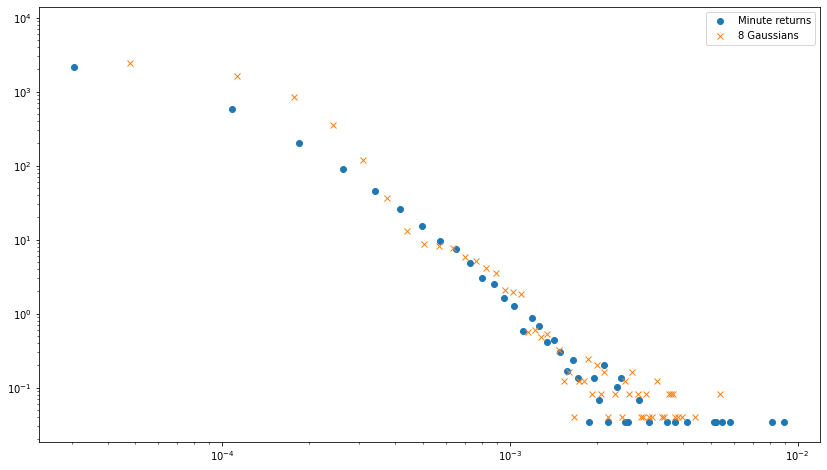

In [235]:
plt.figure(figsize=(14,8))

plt.yscale('log')
plt.xscale('log')
plt.plot(minute_return_hist[1][:-1],minute_return_hist[0],'o', label='Minute returns')
plt.plot(minute_gmm_hist[1][:-1],minute_gmm_hist[0],'x', label='8 Gaussians')
plt.legend()
plt.show()

Попробуем повторить результаты эксперимента, приведенного на изображении

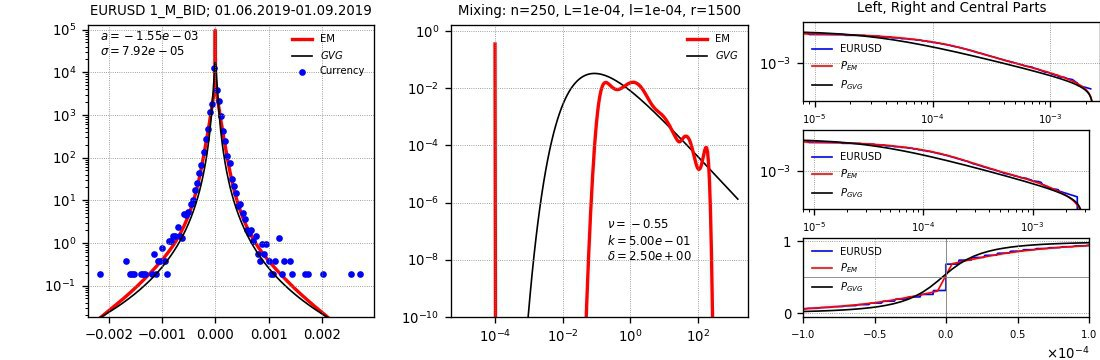

In [173]:
from IPython.display import Image
Image('Pictures/Repin_EM.jpg')

Для моделирования распределения минутных данных по возвратам валютного курса EUR/USD используется смесь гауссиан из 250 компонент. Возьмем тот же промежуток времени (с 01.06.19 по 01.09.19, примерно).

In [4]:
minute_return_6_9 = pd.read_csv('DATA/EURUSD_Minute_RETURN_05.06.2019-04.09.2019.csv')

In [5]:
minute_return_6_9.shape

(126179, 1)

In [179]:
n_components = [i for i in range(200, 261, 10)]
bics, bics_err = BIC_evaluation(minute_return_6_9, n_components, iterations=5)

_____________________________________
n_components: 200	mean BIC: -1501530.3767333082
_____________________________________
n_components: 210	mean BIC: -1501178.0130289725
_____________________________________
n_components: 220	mean BIC: -1500825.6493245247
_____________________________________
n_components: 230	mean BIC: -1500473.285620103
_____________________________________
n_components: 240	mean BIC: -1500120.9219156809
_____________________________________
n_components: 250	mean BIC: -1499768.5582113222
_____________________________________
n_components: 260	mean BIC: -1499416.1945069642


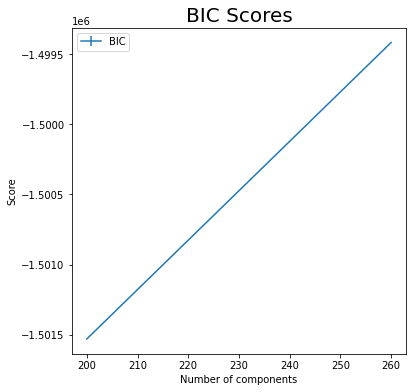

In [183]:
plt.figure(figsize=(6,6))

plt.errorbar(n_components, bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.legend()

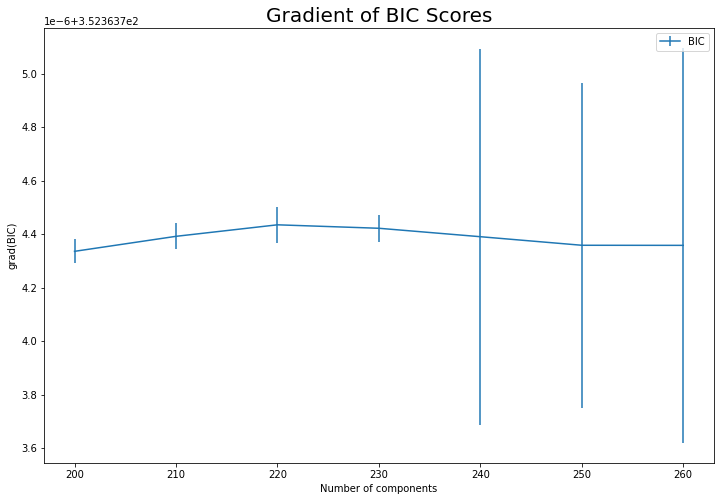

In [184]:
plt.figure(figsize=(12,8))

plt.errorbar(n_components, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("grad(BIC)")
plt.legend()

In [26]:
minute_6_9_gmm = GaussianMixture(n_components=10, covariance_type='full', reg_covar=1e-9, random_state=42)
minute_6_9_gmm.fit(minute_return_6_9)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=42, reg_covar=1e-09,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
/home/dimitry/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


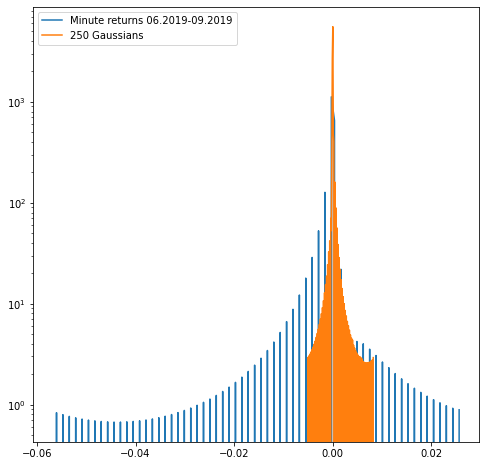

In [7]:
plt.figure(figsize=(8,8))
plt.yscale('log')

sns.kdeplot(data=minute_return_6_9.iloc[:, 0], label='Minute returns 06.2019-09.2019', shade=True)
sns.kdeplot(minute_6_9_gmm.sample(minute_return_6_9.shape[0])[0][:, 0], label='250 Gaussians', shade=True)
plt.legend()

plt.show()

In [8]:
minute_return_6_9_hist = np.histogram(minute_return_6_9 ,bins = 1000, normed=True)
minute_6_9_gmm_hist = np.histogram(minute_6_9_gmm.sample(minute_return_6_9.shape[0])[0], bins=1000, normed=True)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


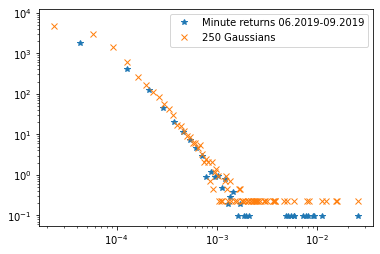

In [9]:
plt.yscale('log')
plt.xscale('log')
plt.plot(minute_return_6_9_hist[1][:-1],minute_return_6_9_hist[0],'*', label='Minute returns 06.2019-09.2019')
plt.plot(minute_6_9_gmm_hist[1][:-1],minute_6_9_gmm_hist[0],'x', label='250 Gaussians')
plt.legend()
plt.show()

In [25]:
minute_6_9_gmm.

1e-09

In [10]:
# n_clusters=np.arange(2, 20)
# sils=[]
# sils_err=[]
# iterations=20
# for n in n_clusters:
#     tmp_sil=[]
#     for _ in range(iterations):
#         gmm=GaussianMixture(n, n_init=2).fit(day_return) 
#         labels=gmm.predict(day_return)
#         sil=metrics.silhouette_score(day_return, labels, metric='euclidean')
#         tmp_sil.append(sil)
#     val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
#     err=np.std(tmp_sil)
#     sils.append(val)
#     sils_err.append(err)

In [ ]:
# plt.errorbar(n_clusters, sils, yerr=sils_err)
# plt.title("Silhouette Scores", fontsize=20)
# plt.xticks(n_clusters)
# plt.xlabel("N. of clusters")
# plt.ylabel("Score")

In [39]:
from scipy.stats import hypsecant
from scipy.stats import skew, kurtosis, norminvgauss, norm, kstest, ks_2samp


In [8]:
#day data

In [11]:
day_return

,Close
0,0.013773
1,0.005738
2,-0.001035
3,0.000000
4,0.004776
...,...
4427,-0.004343
4428,0.004038
4429,0.000831
4430,-0.000924


In [14]:
'''norminvgauss'''
a, b, loc, scale = norminvgauss.fit(day_return['Close'])

print(f'params for NIG dist:\n \na = {a}\nb = {b}\nloc = {loc}\nscale = {scale}')

params for NIG dist:
 
a = 0.58680724766606
b = -0.019249083287856603
loc = 0.00014336680072544843
scale = 0.004634865540303689


In [7]:
print(f'params for NIG dist:\n \na = {a}\nb = {b}\nloc = {loc}\nscale = {scale}')
x = np.linspace(-0.03, 0.03, 1000)
NIG = norminvgauss(a, b, loc, scale)

params for NIG dist:
 
a = 0.58680724766606
b = -0.019249083287856603
loc = 0.00014336680072544843
scale = 0.004634865540303689


In [8]:
'''norm'''
loc, scale = norm.fit(day_return['Close'])
Norm = norm(loc, scale)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


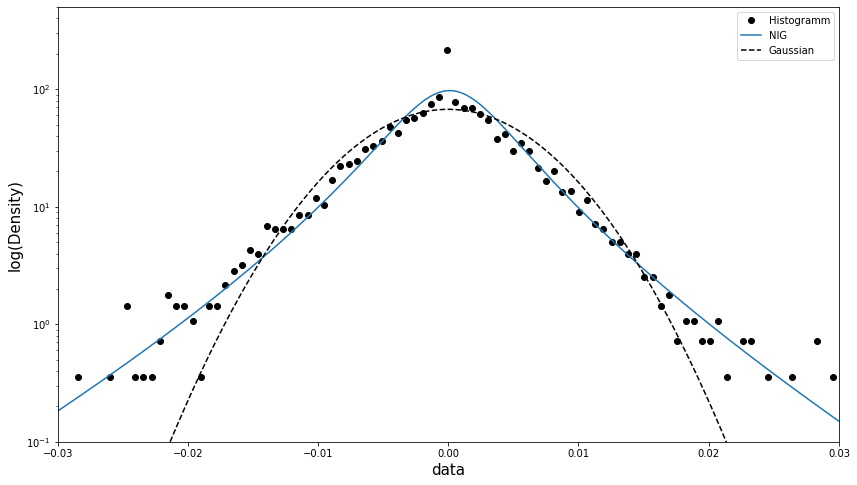

In [9]:
day_return_hist = np.histogram(day_return ,bins = 100, normed=True)

plt.figure(figsize=(14,8))
plt.yscale('log')
plt.axis([-0.03, 0.03, 10**(-1), 10**(2.7) ])
#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, NIG.pdf(x), label='NIG')
plt.plot(x, Norm.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()

plt.show()

In [33]:
kstest(day_return['Close'], 'norminvgauss', (a, b, loc, scale))

KstestResult(statistic=0.04295175663887929, pvalue=1.5816400395523823e-07)

In [29]:
day_return['Close'].min()

-0.028472139850333294

In [39]:
'''norminvgauss'''
a, b, loc, scale = norminvgauss.fit(day_return['Close'])
x = np.linspace(day_return['Close'].min(), day_return['Close'].max(), day_return['Close'].shape[0])

print(f'params for NIG dist:\n \na = {a}\nb = {b}\nloc = {loc}\nscale = {scale}')
NIG = norminvgauss(a, b, loc, scale)
kstest(day_return['Close'], lambda x: NIG.cdf(x), N=50, mode='asymp')

params for NIG dist:
 
a = 0.58680724766606
b = -0.019249083287856603
loc = 0.00014336680072544843
scale = 0.004634865540303689


KstestResult(statistic=0.04295175663887929, pvalue=1.5816400395523823e-07)

In [38]:
kstest(day_return['Close'], lambda x: NIG.cdf(x), N=50, mode='asymp')

KstestResult(statistic=0.04295175663887929, pvalue=1.5816400395523823e-07)

In [34]:
kstest?

In [41]:
'''norminvgauss'''
a_h, b_h, loc_h, scale_h = norminvgauss.fit(hour_return['Close'])
x_h = np.linspace(hour_return['Close'].min(), hour_return['Close'].max(), hour_return['Close'].shape[0])

print(f'params for NIG dist:\n \na = {a}\nb = {b}\nloc = {loc}\nscale = {scale}')
NIG_h = norminvgauss(a_h, b_h, loc_h, scale_h)
#kstest(hour_return['Close'], lambda x: NIG_h.cdf(x), N=50, mode='asymp')

params for NIG dist:
 
a = 0.58680724766606
b = -0.019249083287856603
loc = 0.00014336680072544843
scale = 0.004634865540303689


In [42]:
kstest(hour_return['Close'], 'norminvgauss', (a_h, b_h, loc_h, scale_h))

KstestResult(statistic=0.06592608234138558, pvalue=0.0)

## hypsecant day

In [18]:
#hypsecant
hs_params = hypsecant.fit(day_return['Close'])
HS_loc, HS_scale = hs_params
HypSec = hypsecant(HS_loc, HS_scale)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


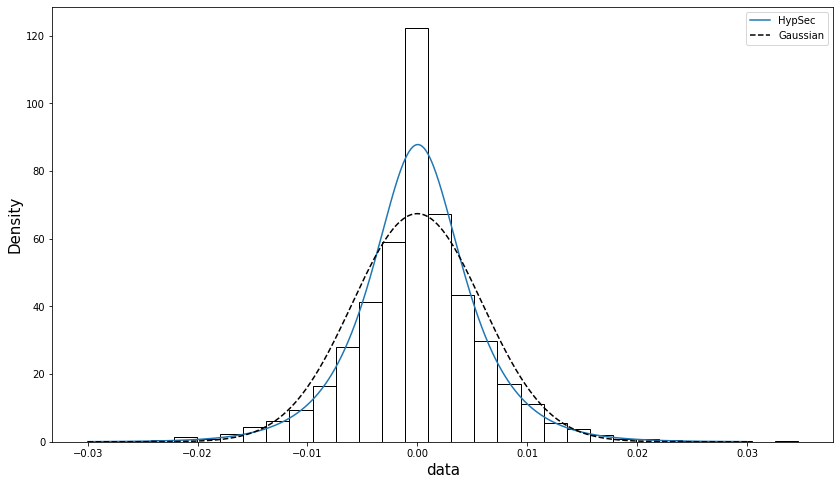

In [19]:
day_return_hist = np.histogram(day_return ,bins = 100, normed=True)
#sns.set(style="white")
plt.figure(figsize=(14,8))
#sns.distplot(day_return.iloc[:, 0], label='Day returns', kde=False, norm_hist=True)
plt.hist(day_return.iloc[:, 0], density=True, bins=30, color='white', ec='black')
#plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec.pdf(x), label='HypSec')
plt.plot(x, Norm.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('Density', size=15)
plt.legend()


plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


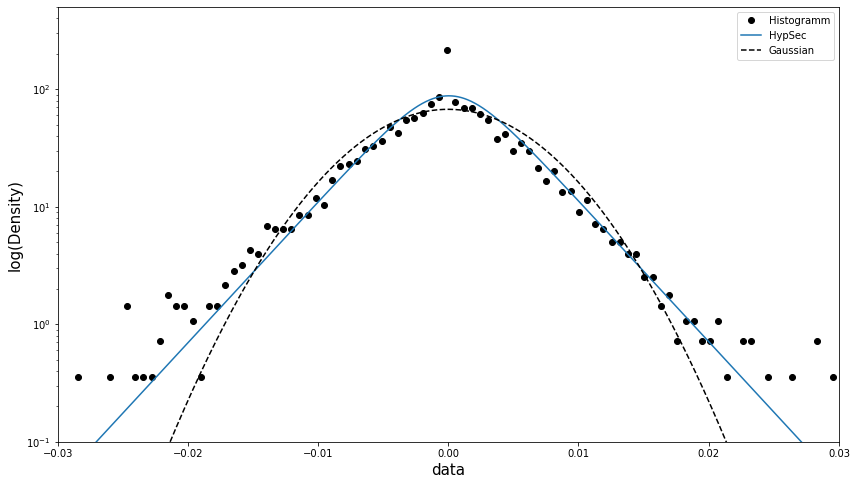

In [20]:
day_return_hist = np.histogram(day_return ,bins = 100, normed=True)

plt.figure(figsize=(14,8))
plt.yscale('log')
plt.axis([-0.03, 0.03, 10**(-1), 10**(2.7) ])
#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec.pdf(x), label='HypSec')
plt.plot(x, Norm.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()

plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


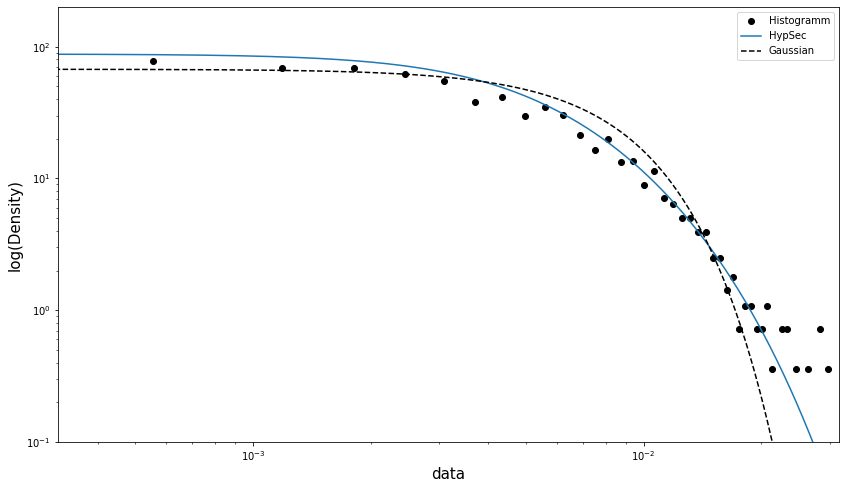

In [21]:
day_return_hist = np.histogram(day_return ,bins = 100, normed=True)

plt.figure(figsize=(14,8))
plt.yscale('log')
plt.xscale('log')

plt.axis([10**(-3.5), 10**(-1.5), 10**(-1), 10**(2.3) ])
#sns.kdeplot(data=day_return.iloc[:, 0], label='Day returns', shade=True)
plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec.pdf(x), label='HypSec')
plt.plot(x, Norm.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()

plt.show()

In [24]:
import numpy as np 
import pylab 
import scipy.stats as stats

plt.figure(figsize=(14,8))

stats.probplot(day_return.iloc[:, 0], dist=HypSec, plot=plt)
plt.title('')
plt.xlabel('Theoretical Quantiles', size=15)
plt.ylabel('Sample Quantiles', size=15)

plt.grid()
plt.legend()
pylab.show()

NameError: name 'HypSec' is not defined

<Figure size 1008x576 with 0 Axes>

In [22]:
'''Hyp'''
kstest(day_return['Close'], 'hypsecant', (HS_loc, HS_scale))

KstestResult(statistic=0.046492260418793674, pvalue=9.550644372622623e-09)

In [26]:
kstest(day_return['Close'], lambda x: HypSec.cdf(x))

KstestResult(statistic=0.046492260418793674, pvalue=9.550644372622623e-09)

In [44]:
'''Hyp'''
HS_loc, HS_scale = hypsecant.fit(hour_return['Close'])
x_h = np.linspace(hour_return['Close'].min(), hour_return['Close'].max(), hour_return['Close'].shape[0])

#print(f'params for HYP dist:\n \na = {a}\nb = {b}\nloc = {loc}\nscale = {scale}')
HypSec_h = hypsecant(HS_loc, HS_scale)
#kstest(hour_return['Close'], lambda x: NIG_h.cdf(x), N=50, mode='asymp')

In [45]:
kstest(hour_return['Close'], 'hypsecant', (HS_loc, HS_scale))

KstestResult(statistic=0.0682701451994367, pvalue=0.0)

In [38]:
day_gmm.score(day_return)

3.776825996730192

In [30]:
day_gmm.sample(day_return['Close'].shape[0])[0].reshape(day_return['Close'].shape[0])

array([0.0048853 , 0.00395446, 0.00227666, ..., 0.00115459, 0.00085979,
       0.00301051])

In [40]:
'''gmm for days ks'''
ks_2samp(day_return['Close'], day_gmm.sample(day_return['Close'].shape[0])[0].reshape(day_return['Close'].shape[0]))

Ks_2sampResult(statistic=0.05121841155234657, pvalue=1.7784065821581707e-05)

In [54]:
'''gmm for days ks'''
ks_2samp(hour_return['Close'], hour_gmm.sample(hour_return['Close'].shape[0])[0].reshape(hour_return['Close'].shape[0]))

Ks_2sampResult(statistic=0.07125129265770425, pvalue=5.9720901882917434e-235)

In [56]:
#Daily models

model_comparing_dict = {'AIC': (-32890.33, -33432.32, -33603.85, -33583.27, -33449.78),
                        'Статистика критерия Колмогорова':(0.066336, 0.052798, 0.044901, 0.046492, 0.051218)}
model_comparing_df = pd.DataFrame(model_comparing_dict, index=('Gaussian', 'NIG', 'HYP', 'HypSec', 'Gaussian mixture'))
model_comparing_df

,AIC,Статистика критерия Колмогорова
Gaussian,-32890.33,0.066336
NIG,-33432.32,0.052798
HYP,-33603.85,0.044901
HypSec,-33583.27,0.046492
Gaussian mixture,-33449.78,0.051218


Гиперболическое распределение, так же как и гиперболическое секанс распределение имеют некоторые различия с эмпирическим распределением, но эти различия проявляются в меньшей степени, чем у гауссовского распределения, нормального обратного гауссовского или распределения смеси. Данное утверждение подкрепляется как квантильными графиками, так и критерием Колмогорова, основанным на максимальной абсолютной разнице эмпирического и теоретической функций распределения.

В таблице представлены расстояния между пятью моделями, в том числе гауссовской, и распределением логарифмической доходности валютного курса EUR/USD по дням. Значение статистики критерия Колмогорова показывает, что наименьшее расстояние между реальными данными и моделью у гиперболического распределения. Статистика для гиперболического секанс распределения немногим больше, что также согласуется с квантильным графиком.


Еще один критерий для сравнения моделей - информационный критерий Акаике. Чем меньше значение этого критерия для конкретной модели, тем выше относительное качество этой модели. В таблице видно, что самое маленькое значение критерия у гиперболического распределения, следом за ним идет гиперболическое секанс распределение.


Основываясь на приведенных критериях модель, основанная на гауссовском распределении снова показало себя заметно хуже альтернативных моделей.

In [57]:
#Hour models

model_comparing_dict = {'AIC': (-1127969, -1188574, -1174303, -1175303, -1177261),
                        'Статистика критерия Колмогорова':(0.12319, 0.059128, 0.06861, 0.06827, 0.060251)}
model_comparing_df = pd.DataFrame(model_comparing_dict, index=('Gaussian', 'NIG', 'HYP', 'HypSec', 'Gaussian mixture'))
model_comparing_df

,AIC,Статистика критерия Колмогорова
Gaussian,-1127969,0.123190
NIG,-1188574,0.059128
HYP,-1174303,0.068610
HypSec,-1175303,0.068270
Gaussian mixture,-1177261,0.060251


Для данных о логарифмической доходности валютного курса EUR/USD по часам качество моделей предстает иным, в некотором смысле, противоположным образом. Исходя из значений статистик критерия Колмогорова, можно сделать вывод о том, что для данных с по-часовым разбинием наиболее близкие распределения имеют модели NIG и смеси из 8 гауссиан. В то же время, модели,которые лучше проявили себя на дневных данных, стали хуже приближать распределения доходности по часам.

Критерий Акаике показывает достаточно большой разрыв между нормальным обратным гауссовским распределением и остальными моделями. Таким образом относительное качество этой модели самое высокое.

Данные значения критериев согласуются с графиками плотности распределений. Действительно, поведение хвостов NIG модели лучше других аппроксимирует хвосты эмпирического распределения. При этом у вершины распределения наблюдаются некоторые сложности с аппроксимацией (то же гиперболическое распределение лучше приближает реальные данные для вершины). Для задачи оценки рисков важнее всего совпадение хвостов распределения изучаемого процесса и модели, что делает данный недостаток несущественным в контексте конкректной проблемы.

## hypsecant hour

In [92]:
#hypsecant
hs_params = hypsecant.fit(hour_return['Close'])
HS_loc, HS_scale = hs_params
HypSec_hour = hypsecant(HS_loc, HS_scale)

In [93]:
'''norm'''
loc, scale = norm.fit(hour_return['Close'])
Norm_hour = norm(loc, scale)

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


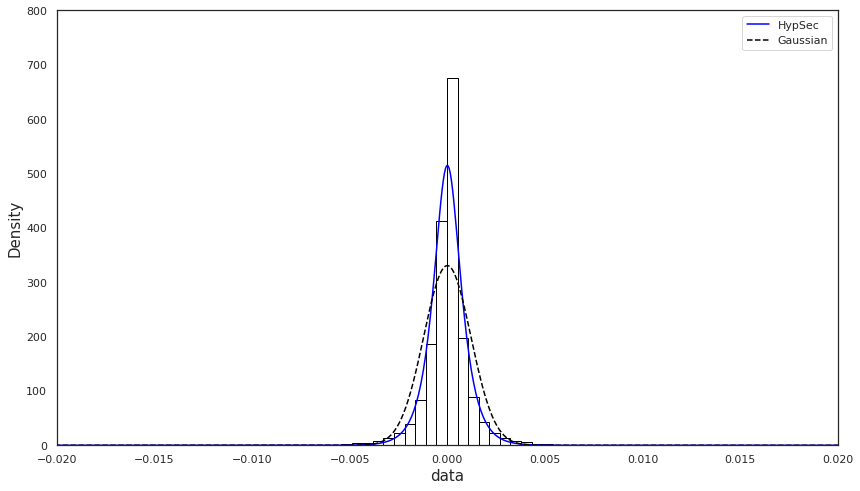

In [100]:
day_return_hist = np.histogram(hour_return ,bins = 100, normed=True)
#sns.set(style="white")
plt.figure(figsize=(14,8))
plt.axis([-0.02, 0.02, 0, 801])
#sns.distplot(day_return.iloc[:, 0], label='Day returns', kde=False, norm_hist=True)
plt.hist(hour_return.iloc[:, 0], density=True, bins=80, color='white', ec='black')
#plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec_hour.pdf(x), label='HypSec', color='blue')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('Density', size=15)
plt.legend()


plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


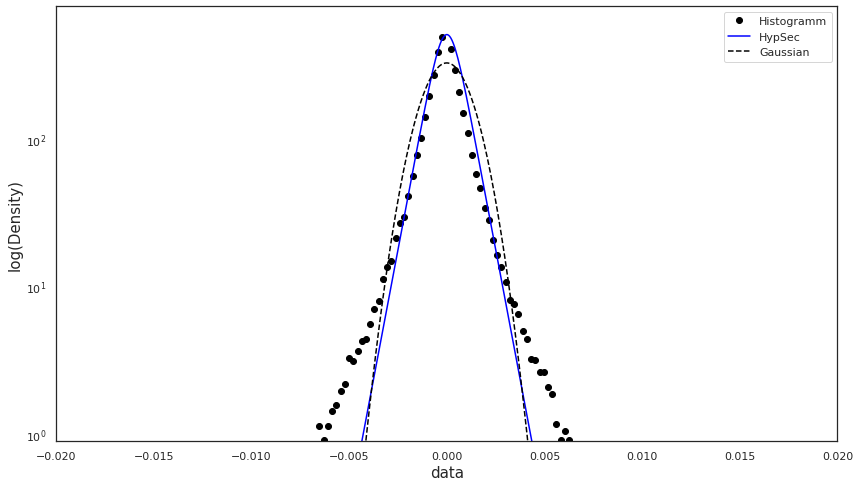

In [111]:
hour_return_hist = np.histogram(hour_return ,bins = 200, normed=True)
plt.figure(figsize=(14,8))
plt.yscale('log')

plt.axis([-0.02, 0.02, 0, 801])
#sns.distplot(day_return.iloc[:, 0], label='Day returns', kde=False, norm_hist=True)
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o',  color='black', label='Histogramm')
#plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec_hour.pdf(x), label='HypSec', color='blue')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()


plt.show()

/home/dimitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


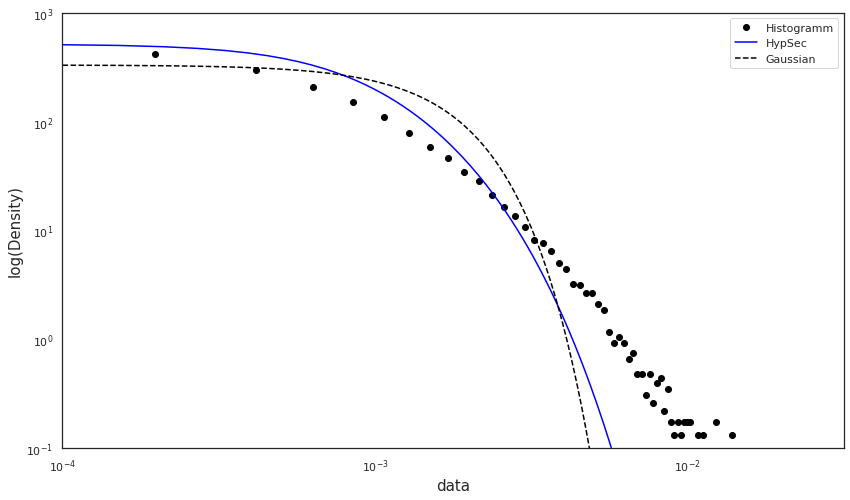

In [115]:
hour_return_hist = np.histogram(hour_return ,bins = 200, normed=True)
plt.figure(figsize=(14,8))
plt.yscale('log')
plt.xscale('log')
plt.axis([10**(-4), 10**(-1.5), 10**(-1), 10**(3) ])
#sns.distplot(day_return.iloc[:, 0], label='Day returns', kde=False, norm_hist=True)
plt.plot(hour_return_hist[1][:-1],hour_return_hist[0],'o',  color='black', label='Histogramm')
#plt.plot(day_return_hist[1][:-1],day_return_hist[0],'o',  color='black', label='Histogramm')
plt.plot(x, HypSec_hour.pdf(x), label='HypSec', color='blue')
plt.plot(x, Norm_hour.pdf(x), '--', color='black', label='Gaussian')
plt.xlabel('data', size=15)
plt.ylabel('log(Density)', size=15)
plt.legend()


plt.show()

No handles with labels found to put in legend.


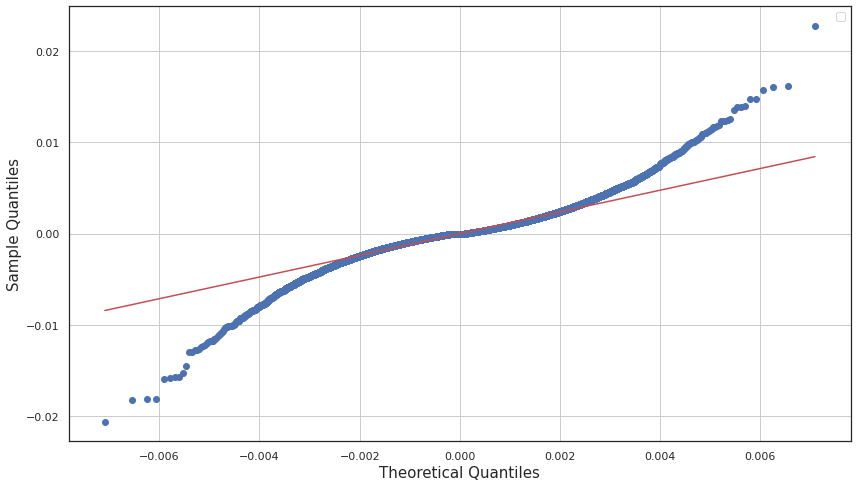

In [116]:
import numpy as np 
import pylab 
import scipy.stats as stats

plt.figure(figsize=(14,8))

stats.probplot(hour_return.iloc[:, 0], dist=HypSec_hour, plot=plt)
plt.title('')
plt.xlabel('Theoretical Quantiles', size=15)
plt.ylabel('Sample Quantiles', size=15)

plt.grid()
plt.legend()
pylab.show()

In [ ]:
'''Hyp'''
kstest(day_data, 'hypsecant', (HS_loc_1, HS_scale_1))